<div style="padding: 35px;color:white;margin:10;font-size:200%;text-align:center;display:fill;border-radius:10px;overflow:hidden;background-image: url(https://images.pexels.com/photos/7078619/pexels-photo-7078619.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1)"><b><span style='color:black'><strong>Bank Fraud Analysis </strong></span></b> </div> 

In [1]:
import pandas as pd 
import numpy as np  

import matplotlib.pyplot as plt 
%matplotlib inline 
import seaborn as sns   

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score 
from sklearn.pipeline import make_pipeline 
from imblearn.pipeline import make_pipeline 
from imblearn.over_sampling import SMOTE 
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.tree import DecisionTreeClassifier 
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier 


from xgboost import XGBClassifier
from catboost import CatBoostClassifier 

from feature_engine.encoding import CountFrequencyEncoder 



import pickle 

<frozen importlib._bootstrap>:241: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216 from C header, got 232 from PyObject


## <div style="padding: 20px;color:white;margin:10;font-size:90%;text-align:left;display:fill;border-radius:10px;overflow:hidden;background-image: url(https://w0.peakpx.com/wallpaper/957/661/HD-wallpaper-white-marble-white-stone-texture-marble-stone-background-white-stone.jpg)"><b><span style='color:black'> Data Understanding</span></b> </div>


In [2]:
df = pd.read_csv("Fraud.csv")
df.head()

,Date,nameOrig,amount,oldbalanceOrg,newbalanceOrig,City,type,Card Type,Exp Type,Gender,isFraud
0,26-May-13,C2011200430,242.0,302.0,60.0,"Ahmedabad, India",TRANSFER,Gold,Food,F,1
1,26-Jul-12,C931301500,7081.0,46066.0,38985.0,"Delhi, India",TRANSFER,Gold,Entertainment,M,1
2,12-Apr-12,C963642457,16355.0,30355.0,14000.0,"Kolkata, India",TRANSFER,Silver,Fuel,F,1
3,28-Jan-12,C1439438217,20820.0,39663.0,18843.0,"Lucknow, India",TRANSFER,Gold,Food,F,1
4,16-Apr-14,C892940485,6071.0,35586.0,29515.0,"Bengaluru, India",TRANSFER,Gold,Fuel,M,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048574 entries, 0 to 1048573
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   Date            1048574 non-null  object 
 1   nameOrig        1048574 non-null  object 
 2   amount          1048574 non-null  float64
 3   oldbalanceOrg   1048574 non-null  float64
 4   newbalanceOrig  1048574 non-null  float64
 5   City            1048574 non-null  object 
 6   type            1048574 non-null  object 
 7   Card Type       1048574 non-null  object 
 8   Exp Type        1048574 non-null  object 
 9   Gender          1048574 non-null  object 
 10  isFraud         1048574 non-null  int64  
dtypes: float64(3), int64(1), object(7)
memory usage: 88.0+ MB


In [4]:
df['Date'] = pd.to_datetime(df['Date'])

In [5]:
df.isna().sum()

Date              0
nameOrig          0
amount            0
oldbalanceOrg     0
newbalanceOrig    0
City              0
type              0
Card Type         0
Exp Type          0
Gender            0
isFraud           0
dtype: int64

In [6]:
df.duplicated().sum()

0

In [7]:
for cols in df.columns:
    print(cols)
    print(df[cols].value_counts())
    print(" ")

Date
2014-04-26    1167
2013-10-14    1159
2014-04-20    1155
2014-06-21    1153
2014-04-23    1143
              ... 
2014-08-12      29
2014-12-22      28
2014-08-29      27
2014-07-30      24
2015-04-11      23
Name: Date, Length: 1326, dtype: int64
 
nameOrig
C1900095842    2
C620899653     2
C1396133766    2
C869403888     2
C1039623203    2
              ..
C1111709107    1
C2143780593    1
C502290755     1
C839317242     1
C1841909664    1
Name: nameOrig, Length: 1048316, dtype: int64
 
amount
0.00         180353
15.00           555
3.00            425
1.00            422
4.00            389
              ...  
12663.28          1
70.08             1
48511.84          1
10075.09          1
121569.82         1
Name: amount, Length: 448247, dtype: int64
 
oldbalanceOrg
0.00           180128
10100000.00       433
10300000.00       424
10200000.00       421
10900000.00       387
                ...  
324338.00           1
91502.00            1
90403.44            1
104801.95        

In [8]:
df['isFraud'].value_counts(normalize=True)

0    0.832358
1    0.167642
Name: isFraud, dtype: float64

There is evidence of class imbalance because the transactions flagged as Fraud are only 16%. Oversampling techniques will be used to handle the class imbalance issue during the modelling phase to avoid a biased model towards the majority class. 

## <div style="padding: 20px;color:white;margin:10;font-size:90%;text-align:left;display:fill;border-radius:10px;overflow:hidden;background-image: url(https://w0.peakpx.com/wallpaper/957/661/HD-wallpaper-white-marble-white-stone-texture-marble-stone-background-white-stone.jpg)"><b><span style='color:black'> Data Preprocessing and Analysis</span></b> </div>

From the date column, we will engineer new features for month, year and day to get the pattern and distribution of fraudalent and non-fraudalent transactions. 

In [9]:
eda_df = df.copy()

In [10]:
eda_df['Month'] = eda_df['Date'].dt.month
eda_df['Year'] = eda_df['Date'].dt.year 
eda_df['Week'] = eda_df['Date'].dt.week 

C:\Users\user\AppData\Local\Temp\ipykernel_4152\595705315.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  eda_df['Week'] = eda_df['Date'].dt.week


<AxesSubplot: xlabel='isFraud', ylabel='count'>

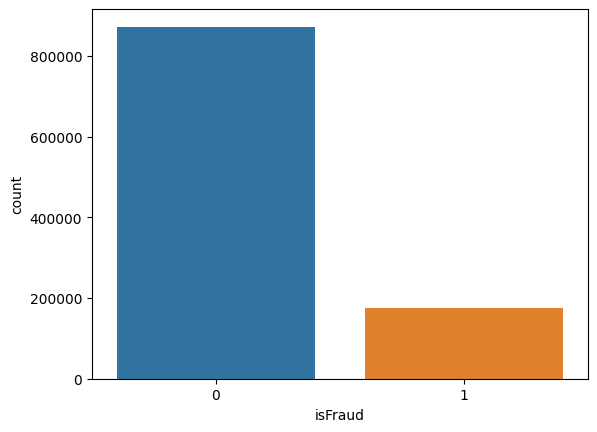

In [11]:
# Target column distribution 
sns.countplot(data=eda_df, x='isFraud')

In [12]:
eda_df['Exp Type']

0                   Food
1          Entertainment
2                   Fuel
3                   Food
4                   Fuel
               ...      
1048569             Fuel
1048570          Grocery
1048571             Fuel
1048572          Grocery
1048573            Bills
Name: Exp Type, Length: 1048574, dtype: object

In [13]:
most_fraud = eda_df.groupby(['Card Type','Exp Type'])['isFraud'].value_counts().unstack().fillna(0)
most_fraud

isFraud                       0     1
Card Type Exp Type                   
Classic   Home               36     4
          Personal_Care      31     9
Gold      Bills           42118  8444
          Entertainment   38346  7583
          Food            44280  8978
          Fuel            44028  8965
          Grocery         37535  7416
          Travel           7092  1388
Mass      Food               35     5
          Health_Fitness     34     6
Platinum  Bills           41142  8357
          Entertainment   39770  7920
          Food            46014  9189
          Fuel            43549  8879
          Grocery         37972  7422
          Travel           6039  1121
Signature Bills           42170  8531
          Entertainment   39198  7804
          Food            44538  8961
          Fuel            43002  8784
          Grocery         40946  8233
          Travel           6017  1143
Silver    Bills           44614  9126
          Entertainment   42269  8523
          Food            48314  9801
          Fuel            45268  9355
          Grocery         42793  8757
          Travel           5639  1081

In [14]:
most_amount = eda_df.groupby(['isFraud','Card Type','Exp Type'])['amount'].agg(['mean','max'])
most_amount

mean          max
isFraud Card Type Exp Type                                 
0       Classic   Home            25876.370278    241270.28
                  Personal_Care   45460.550323    374530.54
        Gold      Bills           40623.586070   1891886.65
                  Entertainment   40925.102144   2962079.84
                  Food            40074.541750   1954092.13
                  Fuel            40343.658280   1765452.97
                  Grocery         40687.291288   2072097.35
                  Travel          42378.820527   1792330.95
        Mass      Food            21479.189429    309689.87
                  Health_Fitness  41787.432059    236017.51
        Platinum  Bills           40208.808583   2554999.36
                  Entertainment   40031.687927   1105180.01
                  Food            40078.015535   2194160.57
                  Fuel            41068.100350   1321968.30
                  Grocery         40432.733974   1632397.31
                  Travel          40340.499472   1183182.40
        Signature Bills           40137.514156   2536199.21
                  Entertainment   40516.907024   2802396.20
                  Food            40759.565930   2121878.54
                  Fuel            40599.115896   2537071.55
                  Grocery         40471.720276   1871671.54
                  Travel          41650.014690   1010199.43
        Silver    Bills           39925.158310   2900409.16
                  Entertainment   40842.963207   1632536.69
                  Food            39898.222784   1855490.28
                  Fuel            40883.496434   2412843.02
                  Grocery         40857.779824   2000538.78
                  Travel          42136.657966   1609288.13
1       Classic   Home            10306.500000     18864.00
                  Personal_Care   11928.555556     21098.00
        Gold      Bills           27545.602087  10000000.00
                  Entertainment   25095.440108  10000000.00
                  Food            25621.030750  10000000.00
                  Fuel            23474.447604  10000000.00
                  Grocery         24988.543366   7108914.22
                  Travel          20783.641765   2701905.30
        Mass      Food             8845.800000     13526.00
                  Health_Fitness  14072.833333     22508.00
        Platinum  Bills           24026.532782   6188772.44
                  Entertainment   25135.292444   8924971.59
                  Food            29969.543210  10000000.00
                  Fuel            26411.610964  10000000.00
                  Grocery         25885.319807   7937954.20
                  Travel          18986.370455    460635.82
        Signature Bills           24039.321534   7728992.56
                  Entertainment   25410.196161  10000000.00
                  Food            26186.236241   9039246.82
                  Fuel            24187.841996   9465988.82
                  Grocery         26121.080978   9887819.06
                  Travel          16074.130446    515818.00
        Silver    Bills           26102.857119  10000000.00
                  Entertainment   28394.942527  10000000.00
                  Food            24604.759667  10000000.00
                  Fuel            26646.133401   9977761.05
                  Grocery         28998.772147   9039246.82
                  Travel          20718.728575   2701905.30

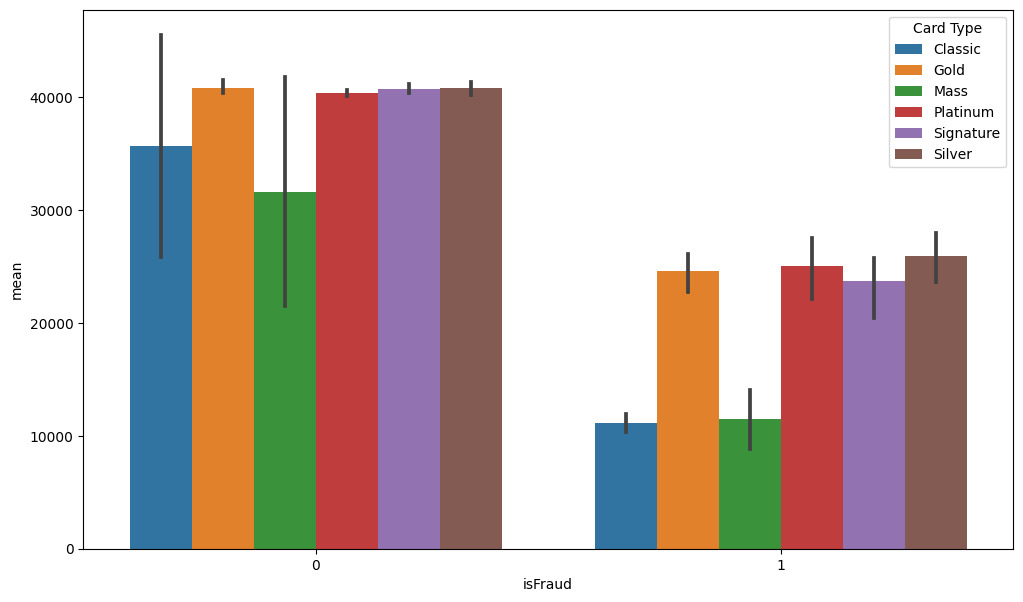

In [15]:
plt.figure(figsize=(12,7))
sns.barplot(data=most_amount.reset_index(), y='mean', x='isFraud', hue='Card Type')
plt.show()

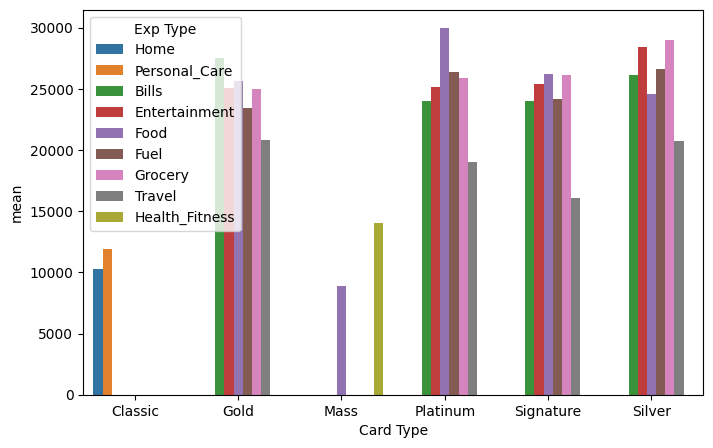

In [16]:
plt.figure(figsize=(8,5))
fraud_amounts = most_amount.loc[1]
sns.barplot(data=fraud_amounts.reset_index(), y='mean', x='Card Type', hue='Exp Type')  
plt.show()

<AxesSubplot: xlabel='Year', ylabel='count'>

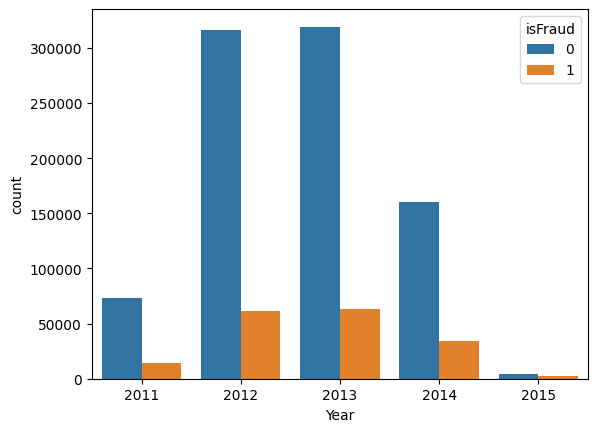

In [17]:
sns.countplot(data=eda_df, x='Year', hue='isFraud')

<AxesSubplot: xlabel='Year'>

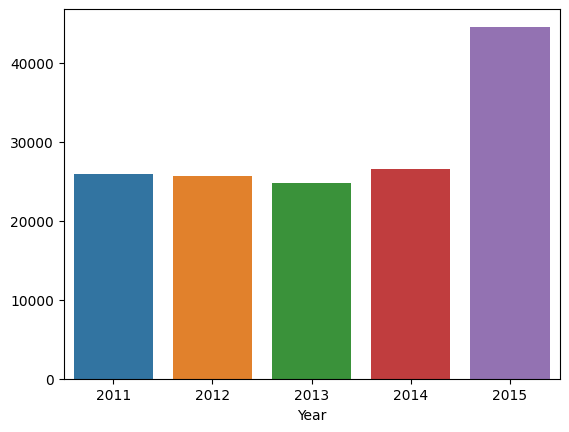

In [18]:
# Average amount per year flagged as fraudalent transactions 
year_group = eda_df.groupby(['isFraud','Year'])['amount'].agg('mean')
year_groups = year_group.loc[1]
sns.barplot(x=year_groups.index, y=year_groups.values)


<AxesSubplot: xlabel='Month', ylabel='count'>

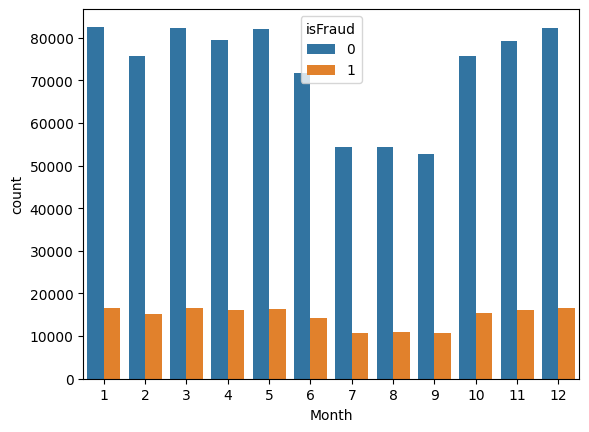

In [19]:
sns.countplot(data=eda_df, x='Month', hue='isFraud')

<AxesSubplot: xlabel='type', ylabel='count'>

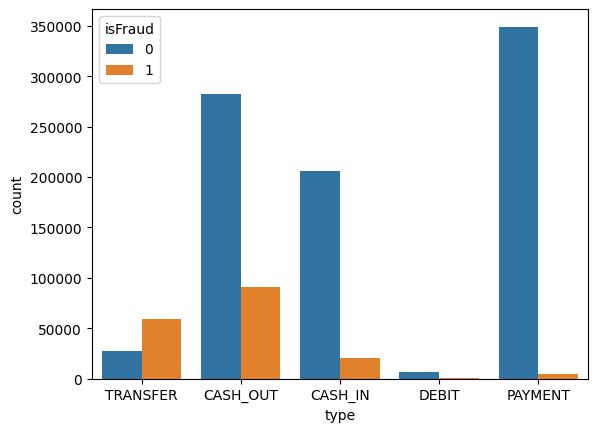

In [20]:
sns.countplot(data=eda_df, x='type', hue='isFraud')

<AxesSubplot: xlabel='type', ylabel='count'>

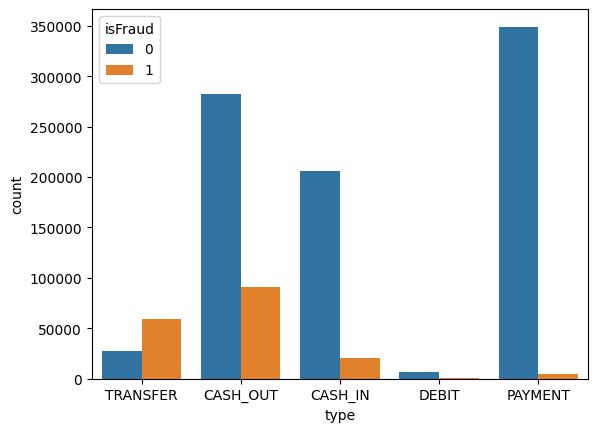

In [21]:
sns.countplot(data=eda_df, x='type', hue='isFraud')

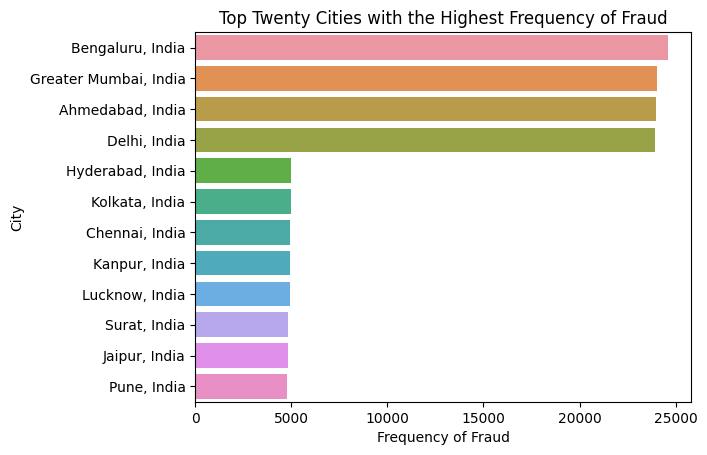

In [22]:
# Top twenty most fraudalent cities 
top_cities_fraud = eda_df[eda_df['isFraud'] == 1]['City'].value_counts().head(12)
sns.barplot(x=top_cities_fraud.values, y=top_cities_fraud.index)
plt.xlabel('Frequency of Fraud')
plt.ylabel('City')
plt.title('Top Twenty Cities with the Highest Frequency of Fraud')
plt.show()

In [23]:
def frequency(df, columns):
    for column in columns:
        frequencies = df[column].value_counts()
        df[column] = df[column].map(frequencies)
    return df 

freq = ['City']
eda_df = frequency(eda_df, freq)

In [24]:
eda_df['Gender'].unique()

array(['F', 'M'], dtype=object)

In [25]:
transaction_type = {
    'TRANSFER' : 1,
    'CASH_OUT' : 2,
    'CASH_IN' : 4,
    'DEBIT' : 0, 
    'PAYMENT' : 3
}

eda_df['type'] = eda_df.type.replace(transaction_type).astype(int)

card_types = {
    'Gold': 3,
    'Silver': 2,
    'Signature' : 5,
    'Platinum' : 4,
    'Classic' : 0,
    'Mass' : 1
}

eda_df['Card Type'] = eda_df['Card Type'].replace(card_types).astype(int)

gender = {'F': 0, 'M': 1}

eda_df['Gender'] = eda_df.Gender.replace(gender).astype(int) 

le = LabelEncoder()
eda_df['Exp Type'] = le.fit_transform(eda_df['Exp Type'])

In [26]:
eda_df = eda_df.drop(columns=['nameOrig'], axis=1)

C:\Users\user\AppData\Local\Temp\ipykernel_4152\3596167122.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(eda_df.corr(), cmap="RdYlBu_r", annot=True)


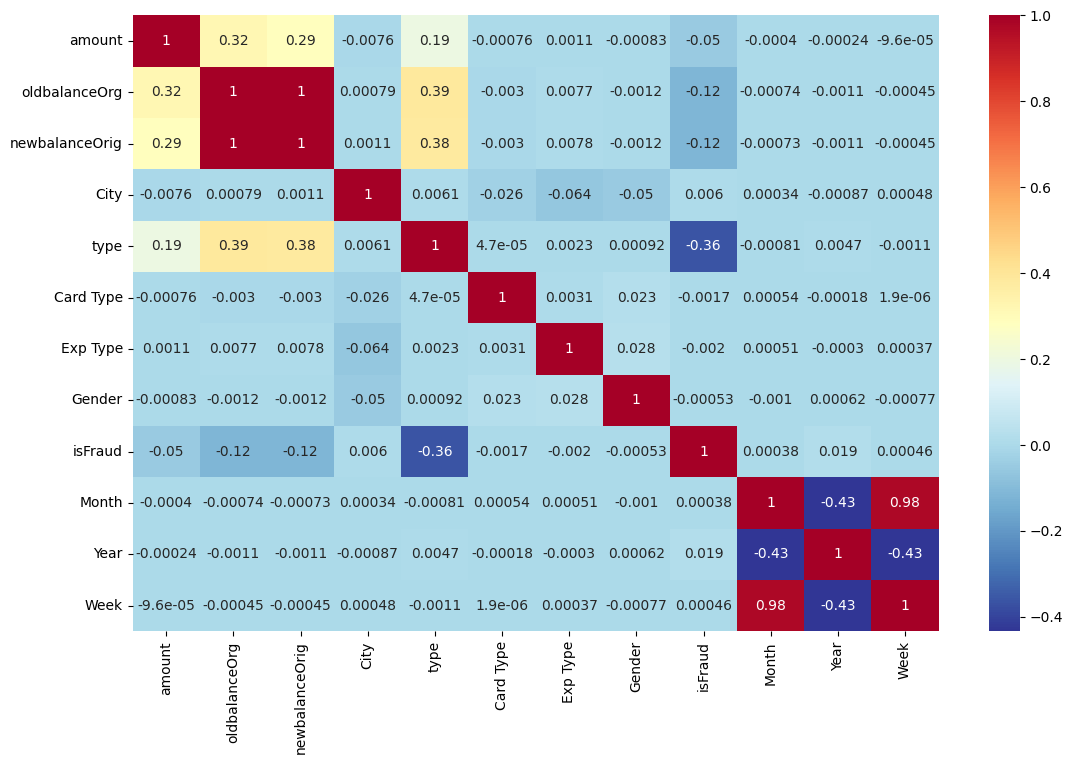

In [27]:
plt.figure(figsize=(13,8))
sns.heatmap(eda_df.corr(), cmap="RdYlBu_r", annot=True)
plt.show() 

## <div style="padding: 20px;color:white;margin:10;font-size:90%;text-align:left;display:fill;border-radius:10px;overflow:hidden;background-image: url(https://w0.peakpx.com/wallpaper/957/661/HD-wallpaper-white-marble-white-stone-texture-marble-stone-background-white-stone.jpg)"><b><span style='color:black'> Modelling</span></b> </div>


In [5]:
modelling_df = df.copy()
modelling_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048574 entries, 0 to 1048573
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   Date            1048574 non-null  datetime64[ns]
 1   nameOrig        1048574 non-null  object        
 2   amount          1048574 non-null  float64       
 3   oldbalanceOrg   1048574 non-null  float64       
 4   newbalanceOrig  1048574 non-null  float64       
 5   City            1048574 non-null  object        
 6   type            1048574 non-null  object        
 7   Card Type       1048574 non-null  object        
 8   Exp Type        1048574 non-null  object        
 9   Gender          1048574 non-null  object        
 10  isFraud         1048574 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(1), object(6)
memory usage: 88.0+ MB


In [6]:
X = modelling_df.drop(columns=['isFraud','nameOrig'], axis=1)
y = modelling_df['isFraud'] 

In [7]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [8]:
X_train['Year'] = X_train['Date'].dt.year 

X_test['Year'] = X_test['Date'].dt.year 

### <b>4.1 <span style='color:#16C2D5'>|</span> Baseline Model</b>

In [32]:

X = eda_df.drop(columns=['isFraud','Date'], axis=1)

y = eda_df['isFraud']
X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
lr = LogisticRegression()
lr.fit(X_tr, y_tr)

y_pred = lr.predict(X_val)

print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.83      1.00      0.91    174471
           1       1.00      0.00      0.00     35244

    accuracy                           0.83    209715
   macro avg       0.92      0.50      0.45    209715
weighted avg       0.86      0.83      0.76    209715



### <b><span style='color:#16C2D5'>|</span> Pipeline Model</b>

In [9]:
X_train = X_train.drop(columns=['Date'], axis=1)

X_test = X_test.drop(columns=['Date'], axis=1)

In [10]:
X_train.head()

,amount,oldbalanceOrg,newbalanceOrig,City,type,Card Type,Exp Type,Gender,Year
926552,149865.66,1132158.63,982292.97,"Rewa, India",CASH_IN,Silver,Food,F,2014
451771,0.00,0.00,0.00,"Jaipur, India",CASH_OUT,Gold,Grocery,M,2012
402345,417.00,622.00,205.00,"Bengaluru, India",TRANSFER,Gold,Food,M,2014
193759,4353.00,7573.00,3220.00,"Delhi, India",CASH_IN,Platinum,Food,M,2011
910438,10635.34,624214.57,613579.23,"Delhi, India",CASH_IN,Silver,Grocery,F,2012


In [11]:

counts = ['City']
pipe_encoding = make_column_transformer((CountFrequencyEncoder(encoding_method='count', variables=counts), counts),
                                        (OneHotEncoder(), slice(4,8)),
                                        remainder='passthrough')

In [12]:
pipe_oversampling = SMOTE(sampling_strategy="minority")

In [13]:
pipe_scaling = make_column_transformer((MinMaxScaler(), slice(0,9)),
                                       remainder="passthrough")

In [14]:
pipe_feature_selection = SelectKBest(score_func=chi2, k=7)

In [19]:

def model_func(X_train, y_train, X_test, y_test, model):
    y_preds_train = model.fit(X_train, y_train).predict(X_train)
    acc_train = accuracy_score(y_train, y_preds_train)
    print(acc_train)
    
    y_preds_test = model.fit(X_test, y_test).predict(X_test)
    acc_test = accuracy_score(y_test, y_preds_test)
    print(acc_test) 
    
    cm = print(classification_report(y_test, y_preds_test))
    
    return cm  
    

### <b>4.2 <span style='color:#16C2D5'>|</span> Bagging Classifier</b>

In [17]:

pipe_bagging = make_pipeline(pipe_encoding, pipe_oversampling, pipe_scaling, pipe_feature_selection,
                             BaggingClassifier(base_estimator=LogisticRegression()))

In [20]:
model_func(X_train, y_train, X_test, y_test, pipe_bagging)

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.6938837531630279


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.6784896850585938
              precision    recall  f1-score   support

           0       0.84      0.76      0.80    218198
           1       0.19      0.29      0.23     43946

    accuracy                           0.68    262144
   macro avg       0.52      0.52      0.51    262144
weighted avg       0.73      0.68      0.70    262144



### <b>4.3 <span style='color:#16C2D5'>|</span> Random Forest Classifier</b>

In [21]:
pipe_forest = make_pipeline(pipe_encoding, pipe_oversampling, pipe_feature_selection,
                            RandomForestClassifier(class_weight="balanced"))

In [22]:
model_func(X_train, y_train, X_test, y_test, pipe_forest)

0.9985084495759318
0.9985542297363281
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    218198
           1       1.00      0.99      1.00     43946

    accuracy                           1.00    262144
   macro avg       1.00      1.00      1.00    262144
weighted avg       1.00      1.00      1.00    262144



### <b>4.4 <span style='color:#16C2D5'>|</span> XGBOOST Classifier</b>

In [23]:
pipe_xgboost = make_pipeline(pipe_encoding, pipe_oversampling, pipe_scaling, pipe_feature_selection,
                             XGBClassifier())

In [24]:
model_func(X_train, y_train, X_test, y_test, pipe_xgboost)

0.8002187098661038
0.8060264587402344
              precision    recall  f1-score   support

           0       0.95      0.81      0.87    218198
           1       0.45      0.79      0.58     43946

    accuracy                           0.81    262144
   macro avg       0.70      0.80      0.73    262144
weighted avg       0.87      0.81      0.82    262144



### <b>4.5 <span style='color:#16C2D5'>|</span> Catbbost Classifier</b>

In [25]:
pipe_catboost = make_pipeline(pipe_encoding, pipe_oversampling, pipe_scaling, pipe_feature_selection,
                              CatBoostClassifier(logging_level='Silent'))

In [26]:
model_func(X_train, y_train, X_test, y_test, pipe_catboost)

0.8043233345625167
0.8112564086914062
              precision    recall  f1-score   support

           0       0.95      0.82      0.88    218198
           1       0.46      0.79      0.58     43946

    accuracy                           0.81    262144
   macro avg       0.71      0.80      0.73    262144
weighted avg       0.87      0.81      0.83    262144



XGBOOST model gives the best recall and f1 score. Precision cannot be used because of presence of class imbalance.

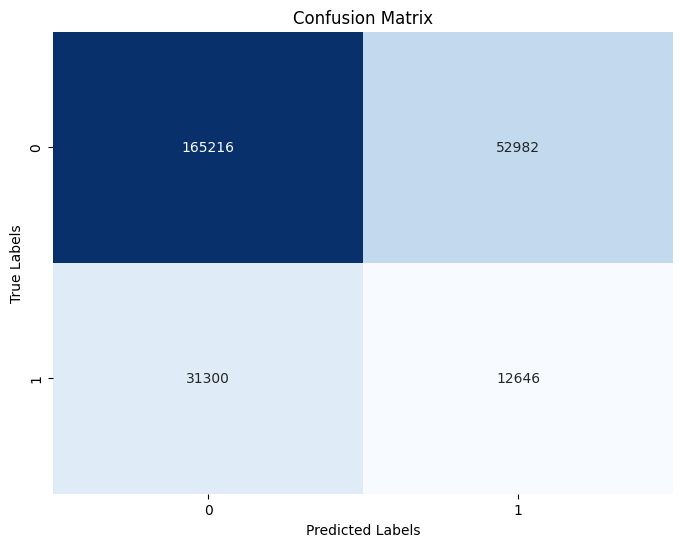

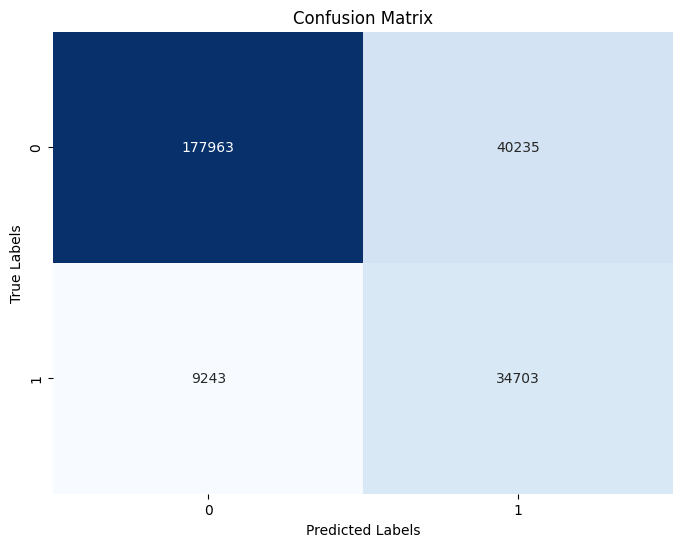

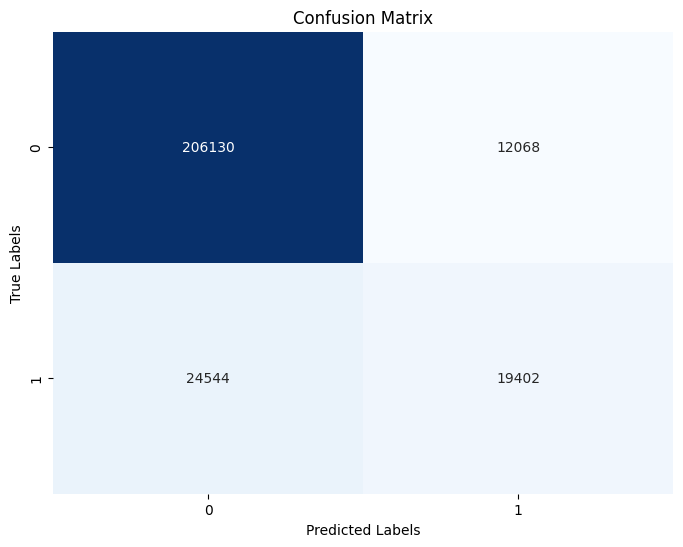

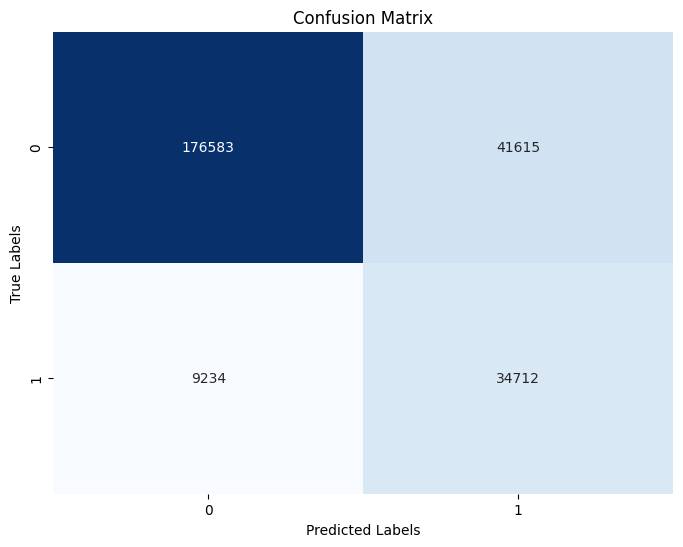

In [27]:
models = [pipe_bagging, pipe_catboost, pipe_forest, pipe_xgboost]

for model in models:
    y_preds_models = model.predict(X_test)
    cm = confusion_matrix(y_test, y_preds_models)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

In [51]:
pipe_xgboost.named_steps

{'columntransformer-1': ColumnTransformer(remainder='passthrough',
                   transformers=[('countfrequencyencoder',
                                  CountFrequencyEncoder(variables=['City']),
                                  ['City']),
                                 ('onehotencoder', OneHotEncoder(),
                                  slice(4, 8, None))]),
 'smote': SMOTE(sampling_strategy='minority'),
 'columntransformer-2': ColumnTransformer(remainder='passthrough',
                   transformers=[('minmaxscaler', MinMaxScaler(),
                                  slice(0, 9, None))]),
 'selectkbest': SelectKBest(k=7, score_func=<function chi2 at 0x000001BBC7DCC160>),
 'xgbclassifier': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
         

### <b><span style='color:#16C2D5'>|</span> Training the data on a sample</b>

Since the data has a million records and may take a lot of time to find the best parameters, we opt to train the model on a 1% sample of 10,000 rows to get the best parameters to train our XGBoost model.

In [30]:

modelling_df_samp = modelling_df.sample(frac=0.01)

X = modelling_df_samp.drop(columns=['isFraud','nameOrig'], axis=1)
y = modelling_df_samp['isFraud']

X_train_samp, X_test_samp, y_train_samp, y_test_samp = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

X_train_samp['Year'] = X_train_samp['Date'].dt.year 
X_test_samp['Year'] = X_test_samp['Date'].dt.year 


X_train_samp = X_train_samp.drop(columns=['Date'], axis=1)

X_test_samp = X_test_samp.drop(columns=['Date'], axis=1)


In [35]:
X_train_samp.isna().sum()

amount            0
oldbalanceOrg     0
newbalanceOrig    0
City              0
type              0
Card Type         0
Exp Type          0
Gender            0
Year              0
dtype: int64

In [36]:
pipe_xgboost.named_steps

{'columntransformer-1': ColumnTransformer(remainder='passthrough',
                   transformers=[('countfrequencyencoder',
                                  CountFrequencyEncoder(variables=['City']),
                                  ['City']),
                                 ('onehotencoder', OneHotEncoder(),
                                  slice(4, 8, None))]),
 'smote': SMOTE(sampling_strategy='minority'),
 'columntransformer-2': ColumnTransformer(remainder='passthrough',
                   transformers=[('minmaxscaler', MinMaxScaler(),
                                  slice(0, 9, None))]),
 'selectkbest': SelectKBest(k=7, score_func=<function chi2 at 0x000002C4F4DB01F0>),
 'xgbclassifier': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
         

In [32]:
param_grid = {
    'xgbclassifier__learning_rate': [0.01, 0.001],
    'xgbclassifier__n_estimators': [50, 100],
    'xgbclassifier__max_depth': [3, 4],
    'xgbclassifier__min_child_weight': [1, 5, 7]
}

grid_search = GridSearchCV(estimator=pipe_xgboost, param_grid=param_grid, scoring='accuracy')

grid_search.fit(X_train_samp, y_train_samp)

best_params = grid_search.best_params_
print("Best Parameters:", best_params)

best_model = grid_search.best_estimator_
y_pred_samp = best_model.predict(X_test_samp)

print(classification_report(y_test_samp, y_pred_samp))

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\feature_engine\encoding\base_encoder.py:255: UserWarning: During the encoding, NaN values were introduced in the feature(s) City.
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Pyt

Best Parameters: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__max_depth': 3, 'xgbclassifier__min_child_weight': 1, 'xgbclassifier__n_estimators': 50}


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\feature_engine\encoding\base_encoder.py:255: UserWarning: During the encoding, NaN values were introduced in the feature(s) City.
  warnings.warn(


ValueError: Input X contains NaN.
SelectKBest does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values